# Twitter sentiment analysis with TFIDF Vectorizer

In [297]:

# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from spacy.lang.en.examples import sentences 
from spacy.cli import download  
from bs4 import BeautifulSoup
# download("en_core_web_sm")
import spacy
import preprocess_kgptalkie as ps  # import the cleaning package
import re  # regex
from dython.model_utils import metric_graph
from dython.nominal import associations
from wordcloud import WordCloud
# from sklearn import set_config
# set_config(display="diagram")
from sklearn import set_config
set_config(display="diagram")
import plotly.express as px

In [298]:
# reading the csv file
df = pd.read_csv("airline_tweets.csv")
df.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)


In [299]:
df.shape

(14640, 15)

In [300]:
df = df.loc[:,["airline","text","airline_sentiment"]] # rassigning df
df.head()

,airline,text,airline_sentiment
0,Virgin America,@VirginAmerica What @dhepburn said.,neutral
1,Virgin America,@VirginAmerica plus you've added commercials t...,positive
2,Virgin America,@VirginAmerica I didn't today... Must mean I n...,neutral
3,Virgin America,@VirginAmerica it's really aggressive to blast...,negative
4,Virgin America,@VirginAmerica and it's a really big bad thing...,negative


In [301]:
df["sentiment_encoded"] = df.airline_sentiment.apply(lambda x: (-1) if x == "negative" else (0) if x == "neutral" else (1) )

In [302]:
df[df.duplicated().values]

,airline,text,airline_sentiment,sentiment_encoded
331,Virgin America,@VirginAmerica Thanks!,positive,1
515,United,@united thanks,positive,1
1477,United,@united thank you!,positive,1
1864,United,@united thank you,positive,1
1938,United,@united thank you,positive,1
...,...,...,...,...
13995,American,@AmericanAir 800 number will not even let you...,negative,-1
14386,American,@AmericanAir I want to speak to a human being!...,negative,-1
14392,American,@AmericanAir no response to DM or email yet. ...,negative,-1
14543,American,@AmericanAir should reconsider #usairways acqu...,negative,-1


In [303]:
df.drop_duplicates(keep ="first", inplace= True)

In [304]:
df.duplicated().sum()

0

In [305]:
df.rename({"text" :"tweets"}, axis =1, inplace = True)

In [306]:
df.isna().sum()

airline              0
tweets               0
airline_sentiment    0
sentiment_encoded    0
dtype: int64

In [307]:
df.dropna(how = "any", inplace = True)

In [308]:
df.shape
df.head()

,airline,tweets,airline_sentiment,sentiment_encoded
0,Virgin America,@VirginAmerica What @dhepburn said.,neutral,0
1,Virgin America,@VirginAmerica plus you've added commercials t...,positive,1
2,Virgin America,@VirginAmerica I didn't today... Must mean I n...,neutral,0
3,Virgin America,@VirginAmerica it's really aggressive to blast...,negative,-1
4,Virgin America,@VirginAmerica and it's a really big bad thing...,negative,-1


In [309]:
df.airline_sentiment.value_counts().index


Index(['negative', 'neutral', 'positive'], dtype='object')

In [310]:
fig= px.pie(df.airline_sentiment.value_counts(), values = df.airline_sentiment.value_counts().values, names =df.airline_sentiment.value_counts().index)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

# Preprocessing and removing stopwords

In [311]:
# def get_clean(x):
#     x = str(x).lower().replace('\\', '').replace('_', ' ')
#     x = ps.cont_exp(x)
#     x = ps.remove_emails(x)
#     x = ps.remove_urls(x)
#     x = ps.remove_html_tags(x)
#     x = ps.remove_rt(x)
#     x = ps.remove_accented_chars(x)
#     x = ps.remove_special_chars(x)
#     x = re.sub("(.)\\1{2,}", "\\1", x)
#     return x


# #cleaning the tweets
# def remove_pattern(input_txt, pattern):
#     r = re.findall(pattern, input_txt)
#     for i in r:
#         input_txt = re.sub(i, '', input_txt)        
#     return input_txt
# def clean_tweets(tweets):
#     #remove twitter Return handles (RT @xxx:)
#     tweets = np.vectorize(remove_pattern)(tweets, "RT @[\w]*:") 
    
#     #remove twitter handles (@xxx)
#     tweets = np.vectorize(remove_pattern)(tweets, "@[\w]*")
    
#     #remove URL links (httpxxx)
#     tweets = np.vectorize(remove_pattern)(tweets, "https?://[A-Za-z0-9./]*")
    
#     #remove special characters, numbers, punctuations (except for #)
#     tweets = np.core.defchararray.replace(tweets, "[^a-zA-Z]", " ")
    
#     return tweets

from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))

def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()



In [312]:
df.tweets = df.tweets.apply(lambda x: tweet_cleaner(x))

c:\Users\godwi\anaconda3\envs\ML\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



In [313]:
tweets= df.tweets.str.split(expand = True,n=1)[1]
df.tweets= tweets
df.isna().sum()

airline                0
tweets               123
airline_sentiment      0
sentiment_encoded      0
dtype: int64

In [314]:
df.tweets

0                                                     said
1         you ve added commercials to the experience tacky
2        didn t today must mean i need to take another ...
3        s really aggressive to blast obnoxious enterta...
4                     it s a really big bad thing about it
                               ...                        
14635          you we got on a different flight to chicago
14636    over minutes late flight no warnings or commun...
14637                bring american airlines to blackberry
14638    have my money you change my flight and don t a...
14639    have ppl so we need know how many seats are on...
Name: tweets, Length: 14452, dtype: object

In [315]:
# view sample cleaned text
df.dropna(inplace= True)
df.isna().sum()

airline              0
tweets               0
airline_sentiment    0
sentiment_encoded    0
dtype: int64

In [316]:
df.to_csv("dataframe.csv", index = False)

In [317]:
X= df.tweets
y= df.sentiment_encoded

# Pipeline with needed libraries

In [318]:

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import TransformerMixin
from sklearn.naive_bayes import MultinomialNB

In [319]:
class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self
    def transform(self, X, y=None, **fit_params):
        return X.todense()

In [359]:
model = Pipeline([('Vect',TfidfVectorizer(max_features = 100000, ngram_range =(1,2),stop_words = 'english')),
                  #('to_dense', DenseTransformer()), 
                   ('mnb', MultinomialNB(alpha=0.02))
                 
                  ])

In [360]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=42)

In [361]:
model.fit(X_train, y_train)

Pipeline(steps=[('Vect',
                 TfidfVectorizer(max_features=100000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('mnb', MultinomialNB(alpha=0.02))])

In [362]:
y_pred = model.predict(X_test )
y_pred

array([-1,  1, -1, ...,  0,  1, -1], dtype=int64)

In [363]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [364]:
accuracy_score(y_test, y_pred)

0.7208653175157014

In [365]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.75      0.92      0.83      1811
           0       0.59      0.32      0.42       617
           1       0.67      0.45      0.54       438

    accuracy                           0.72      2866
   macro avg       0.67      0.56      0.59      2866
weighted avg       0.70      0.72      0.69      2866



In [366]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.75      0.92      0.83      1811
           0       0.59      0.32      0.42       617
           1       0.67      0.45      0.54       438

    accuracy                           0.72      2866
   macro avg       0.67      0.56      0.59      2866
weighted avg       0.70      0.72      0.69      2866



In [367]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[1670,  101,   40],
       [ 361,  199,   57],
       [ 202,   39,  197]], dtype=int64)

In [368]:
pd.DataFrame(cm)

,0,1,2
0,1670,101,40
1,361,199,57
2,202,39,197


<AxesSubplot:>

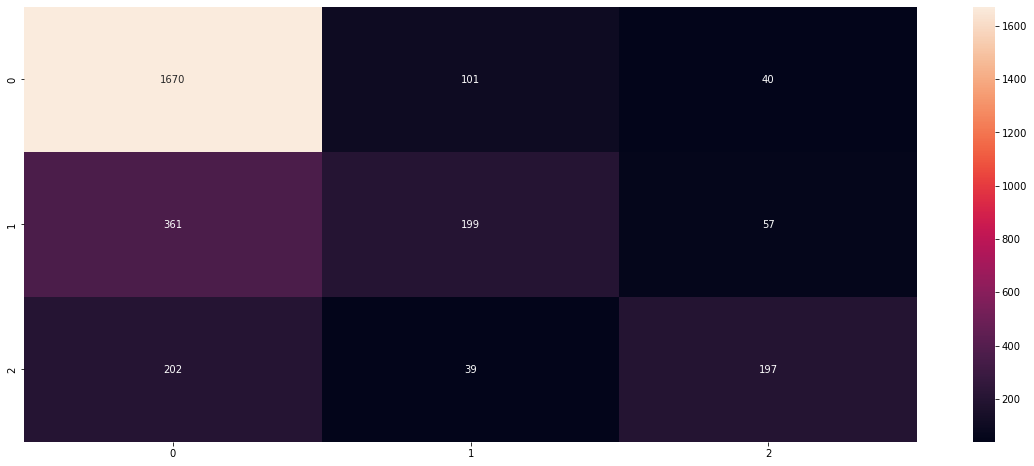

In [369]:
fig, ax = plt.subplots(figsize = (20,8))
sns.heatmap(cm, annot = True, fmt = "d",)

In [370]:
y_proba = model.predict_proba(X_test)
y_proba

array([[0.84248777, 0.13302855, 0.02448368],
       [0.33914904, 0.00965847, 0.65119249],
       [0.90360893, 0.068769  , 0.02762207],
       ...,
       [0.39816007, 0.59984006, 0.00199987],
       [0.15408899, 0.23309182, 0.61281919],
       [0.50607648, 0.43333901, 0.06058451]])

In [371]:
import joblib
joblib.dump(model,"model_twitter.joblib")

['model_twitter.joblib']

In [372]:
df

,airline,tweets,airline_sentiment,sentiment_encoded
0,Virgin America,said,neutral,0
1,Virgin America,you ve added commercials to the experience tacky,positive,1
2,Virgin America,didn t today must mean i need to take another ...,neutral,0
3,Virgin America,s really aggressive to blast obnoxious enterta...,negative,-1
4,Virgin America,it s a really big bad thing about it,negative,-1
...,...,...,...,...
14635,American,you we got on a different flight to chicago,positive,1
14636,American,over minutes late flight no warnings or commun...,negative,-1
14637,American,bring american airlines to blackberry,neutral,0
14638,American,have my money you change my flight and don t a...,negative,-1


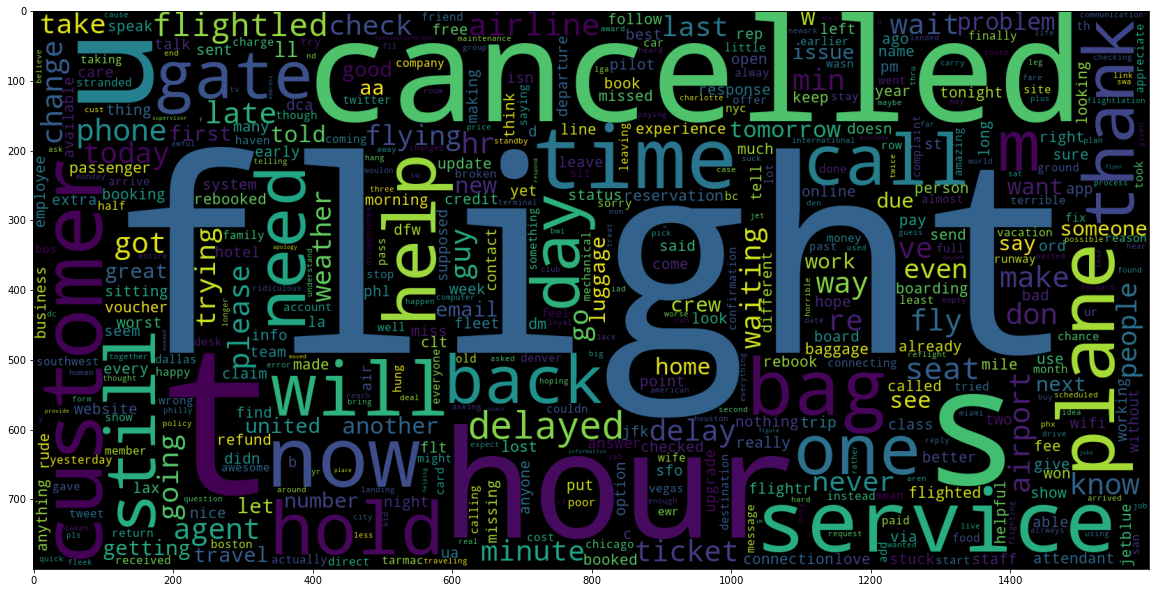

In [354]:
text = "".join(df['tweets'])
fig, ax = plt.subplots(figsize = (20,20))
wc = WordCloud(max_words = 500 , width = 1600 , height = 800,collocations=False).generate(text)
ax.imshow(wc);

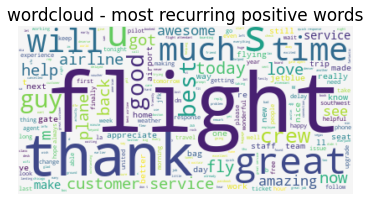

In [355]:
fig, ax = plt.subplots() 
super = df.loc[:,["tweets","airline_sentiment"]]
text = "".join(super[super.airline_sentiment == "positive"].tweets)
wc= WordCloud(max_words = 1000,background_color="whitesmoke", random_state=42,normalize_plurals=True).generate(text)
plt.title("wordcloud - most recurring positive words", fontsize = 17)
plt.axis("off")
#plt.tight_layout(pad=0)
ax.imshow(wc,interpolation="bilinear")


In [356]:
super = df.loc[:,["tweets","airline_sentiment"]]
super[super.airline_sentiment == "negative"].tweets

3        s really aggressive to blast obnoxious enterta...
4                     it s a really big bad thing about it
5        would pay a flight for seats that didn t have ...
15                               pdx schedule is still mia
17       flew from nyc to sfo last week and couldn t fu...
                               ...                        
14631    for nothing on getting us out of the country a...
14633    flight was cancelled flightled leaving tomorro...
14634                               on cue with the delays
14636    over minutes late flight no warnings or commun...
14638    have my money you change my flight and don t a...
Name: tweets, Length: 9075, dtype: object

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

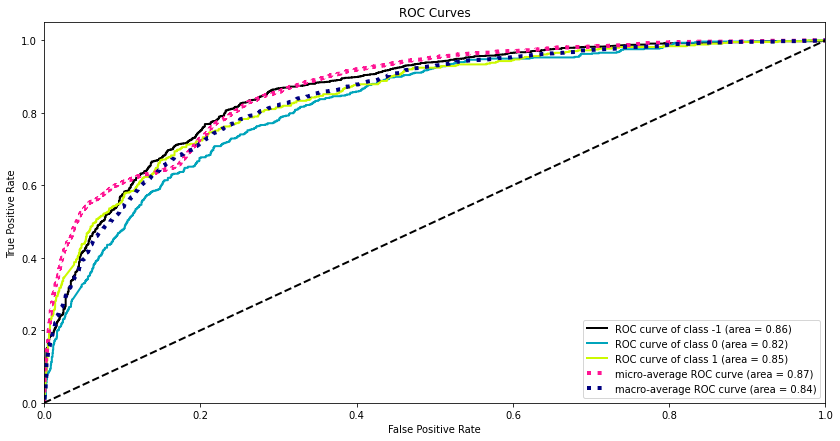

In [357]:
import scikitplot as skplt
fig, ax = plt.subplots(figsize=(14,7))
skplt.metrics.plot_roc(y_test, y_proba,ax= ax)

In [358]:
text = df['tweets'][:4]
text

0                                                 said
1     you ve added commercials to the experience tacky
2    didn t today must mean i need to take another ...
3    s really aggressive to blast obnoxious enterta...
Name: tweets, dtype: object